## 국회의원 현황정보 수집/분석/시각화/저장
* 이름과 ID 추출
* 상세페이지 정보 추출 (json으로 저장)
* 상세정보들을 DataFrame으로 변환
* 시각화(막대그래프,히스토그램, 파이챠트, 히트맵)
* 테이블로 저장

In [2]:
import requests
from bs4 import BeautifulSoup
import re


In [3]:
url = 'https://www.assembly.go.kr/assm/memact/congressman/memCond/memCondListAjax.do'

req_param_dict={
    'currentPage' : 1,
    'rowPerPage' : 300
}

res = requests.get(url, params=req_param_dict)

print(res.status_code)

if res.ok:
    soup=BeautifulSoup(res.text, 'html.parser')
    atag_list = soup.select('div.memberna_list dl dt a')
    #print(len(atag_list))
    
    member_id_list = []
    for atag in atag_list:
        href = atag['href']
        matched = re.search(r'(\d+)', href)        
        if matched:
            member_id = matched.group(0)
        member_id_list.append(member_id)
    print(len(member_id_list))        
    print(member_id_list[:3])

200
295
['9771230', '9771142', '9771174']


In [4]:
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin

print('===> 스크래핑 시작')
member_detail_list = []
for idx,mem_id in enumerate(member_id_list,1):
    detail_url = f'https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd={mem_id}'
    print(idx, detail_url)
    res = requests.get(detail_url)
    if res.ok:
        soup = BeautifulSoup(res.text, 'html.parser')
        
        #1명의 정보를 저장할 dict 선언
        member_detail_dict = {}
        
        dt_list = [dt_tag.text for dt_tag in soup.select('dl.pro_detail dt')]
        
        dd_list = []        
        for dd_tag in soup.select('dl.pro_detail dd'):
            pattern = re.compile(f'[\n\r\t]')
            dd_text = pattern.sub('',dd_tag.text.strip()).replace(" ","")
            dd_list.append(dd_text)
        
        member_detail_dict = dict(zip(dt_list, dd_list))
        
        for div_tag in soup.select('div.profile'):
            member_detail_dict['이름']=div_tag.find('h4').text
            
            img_tag = div_tag.select('img')
            if img_tag:
                member_detail_dict['이미지'] = urljoin(detail_url, img_tag[0]['src'])
            
            member_detail_dict['생년월일'] = div_tag.select_one('li:nth-of-type(4)').text
        
        #1명의 정보가 저장된 dict를 list에 추가하기
        member_detail_list.append(member_detail_dict)

print(len(member_detail_list))        
print('===> 스크래핑 끝')        

===> 스크래핑 시작
1 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771230
2 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771142
3 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771174
4 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771233
5 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771283
6 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9770933
7 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771116
8 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771276
9 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771168
10 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771007
11 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771109
12 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771180
13 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9770931
14 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771224
15 https://www.a

In [5]:
import json

with open('국회의원현황정보.json','w') as file:
    json.dump(member_detail_list, file)

In [6]:
import pandas as pd

member_df = pd.read_json('국회의원현황정보.json')
print(member_df.shape)

(295, 16)


In [7]:
member_df.head(3)

,정당,선거구,소속위원회,당선횟수,사무실 전화,사무실 호실,홈페이지,이메일,보좌관,비서관,비서,"취미, 특기",의원실 안내,이름,이미지,생년월일
0,국민의힘,경남창원시성산구,보건복지위원회,"재선(19대,21대)",02-784-1751,의원회관937호,http://blog.naver.com/ggotop,ggotop@naver.com,"김홍광,한영애","지상훈,최광림","김영록,안효상,이유진,홍지형,김지훈",,,강기윤,https://www.assembly.go.kr/photo/9771230.jpg,1960-06-04
1,국민의힘,대구동구을,"국방위원회,정치개혁특별위원회",초선(21대),02-784-5275,의원회관341호,,kds21341@naver.com,"박홍규,정운태","유진영,이기백","박순권,김광연,김현정,송민욱",,,강대식,https://www.assembly.go.kr/photo/9771142.jpg,1959-11-02
2,더불어민주당,경기안양시만안구,"교육위원회,예산결산특별위원회",초선(21대),02-784-2747~9,의원회관440호,https://blog.naver.com/dulipapa,mainsail440@daum.net,"서용선,안홍식","최경순,홍미하","문형구,최기섭,조나연,오세령,배은경",,강득구의원의'사람중심민생중심'의정활동이국민의삶에힘이되도록열심히하고있습니다.강득구의원...,강득구,https://www.assembly.go.kr/photo/9771174.jpg,1963-05-27


In [8]:
member_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   정당      295 non-null    object
 1   선거구     295 non-null    object
 2   소속위원회   295 non-null    object
 3   당선횟수    295 non-null    object
 4   사무실 전화  295 non-null    object
 5   사무실 호실  295 non-null    object
 6   홈페이지    295 non-null    object
 7   이메일     295 non-null    object
 8   보좌관     295 non-null    object
 9   비서관     295 non-null    object
 10  비서      295 non-null    object
 11  취미, 특기  295 non-null    object
 12  의원실 안내  295 non-null    object
 13  이름      295 non-null    object
 14  이미지     295 non-null    object
 15  생년월일    295 non-null    object
dtypes: object(16)
memory usage: 37.0+ KB


In [10]:
member_df['정당']

0        국민의힘
1        국민의힘
2      더불어민주당
3        국민의힘
4      더불어민주당
        ...  
290    더불어민주당
291      국민의힘
292      국민의힘
293    더불어민주당
294    더불어민주당
Name: 정당, Length: 295, dtype: object

In [11]:
member_df['정당'].unique()

array(['국민의힘', '더불어민주당', '정의당', '국민의당', '무소속', '기본소득당', '시대전환'],
      dtype=object)

In [12]:
member_df['정당'].value_counts()

더불어민주당    172
국민의힘      106
정의당         6
무소속         6
국민의당        3
기본소득당       1
시대전환        1
Name: 정당, dtype: int64

In [13]:
member_df['당선횟수'].value_counts()

초선(21대)                        149
재선(20대,21대)                     60
3선(19대,20대,21대)                 33
4선(17대,19대,20대,21대)             10
재선(19대,21대)                      9
5선(17대,18대,19대,20대,21대)          7
4선(18대,19대,20대,21대)              6
3선(18대,19대,21대)                  3
재선(17대,21대)                      2
4선(16대,17대,18대,21대)              2
5선(16대,17대,18대,20대,21대)          2
3선(17대,19대,21대)                  2
3선(18대,20대,21대)                  2
4선(17대,18대,19대,21대)              1
3선(15대,16대,21대)                  1
6선(16대,17대,18대,19대,20대,21대)      1
5선(16대,17대,18대,19대,21대)          1
5선(15대,16대,19대,20대,21대)          1
3선(17대,18대,21대)                  1
재선(18대,21대)                      1
5선(15대,16대,17대,18대,21대)          1
Name: 당선횟수, dtype: int64

In [14]:
member_df['선거구'].value_counts()

비례대표              47
경남창원시성산구           1
광주광산구갑             1
전남담양군함평군영광군장성군     1
강원원주시갑             1
                  ..
경남창원시의창구           1
충남천안시을             1
서울강북구을             1
부산남구을              1
서울양천구갑             1
Name: 선거구, Length: 249, dtype: int64

In [17]:
member_df['이메일'].head(5)

0          ggotop@naver.com
1        kds21341@naver.com
2      mainsail440@daum.net
3    strongwind01@naver.com
4      kmj2020edu@gmail.com
Name: 이메일, dtype: object

In [18]:
print(type(member_df['당선횟수']))

<class 'pandas.core.series.Series'>


In [20]:
print(type(member_df['당선횟수'].str))
##Series객체를 StringMethods 객체로 변환(문자열 슬라이싱을 하기 위해서)

<class 'pandas.core.strings.accessor.StringMethods'>


In [21]:
temp_str = member_df['당선횟수'].str

In [24]:
print(type(temp_str))
print(temp_str)

<class 'pandas.core.strings.accessor.StringMethods'>


In [31]:
member_df['당선횟수2'] = temp_str[:2]
print(member_df['당선횟수2'])

0      재선
1      초선
2      초선
3      초선
4      초선
       ..
290    초선
291    5선
292    초선
293    초선
294    재선
Name: 당선횟수2, Length: 295, dtype: object


In [34]:
member_df.loc[:5,['당선횟수','당선횟수2']]

,당선횟수,당선횟수2
0,"재선(19대,21대)",재선
1,초선(21대),초선
2,초선(21대),초선
3,초선(21대),초선
4,초선(21대),초선
5,"재선(20대,21대)",재선


In [35]:
member_df['당선횟수2'].value_counts()

초선    149
재선     72
3선     42
4선     19
5선     12
6선      1
Name: 당선횟수2, dtype: int64

In [42]:
# 3선 4선 5선 6선 누구임? 알아보자
# member_df.loc[member_df['당선횟수2'] == '3선'].head(2)
# member_df.loc[member_df['당선횟수2'] == '4선'].head(2)
# member_df.loc[member_df['당선횟수2'] == '5선'].head(2)
member_df.loc[member_df['당선횟수2'] == '6선']

,정당,선거구,소속위원회,당선횟수,사무실 전화,사무실 호실,홈페이지,이메일,보좌관,비서관,비서,"취미, 특기",의원실 안내,이름,이미지,생년월일,당선횟수2
91,무소속,대전서구갑,,"6선(16대,17대,18대,19대,20대,21대)",02-6788-6461,의원회관804호,,pbs2100@gmail.com,"박승규,송석근","김민숙,좌승택","이영해,조연길,최지연,임규보,이초롱",,,박병석,https://www.assembly.go.kr/photo/9770090.jpg,1952-01-25,6선


In [43]:
#선거구를 알아보자 

member_df['선거구']

0      경남창원시성산구
1         대구동구을
2      경기안양시만안구
3        경남진주시을
4          비례대표
         ...   
290      경기고양시병
291      대구수성구을
292     부산중구영도구
293        대전중구
294      서울양천구갑
Name: 선거구, Length: 295, dtype: object

In [44]:
local_str = member_df['선거구'].str

In [45]:
print(local_str)

In [46]:
#선거구 앞 2글자만따서 지역으로 표시해주자 

member_df['선거구2'] = local_str[:2]

In [47]:
print(member_df['선거구2'])

0      경남
1      대구
2      경기
3      경남
4      비례
       ..
290    경기
291    대구
292    부산
293    대전
294    서울
Name: 선거구2, Length: 295, dtype: object


In [49]:
member_df.loc[:10,['선거구','선거구2']]

,선거구,선거구2
0,경남창원시성산구,경남
1,대구동구을,대구
2,경기안양시만안구,경기
3,경남진주시을,경남
4,비례대표,비례
5,서울은평구을,서울
6,서울강서구갑,서울
7,비례대표,비례
8,세종특별자치시을,세종
9,충남아산시을,충남


In [50]:
# 가장 최연소 국회의원과 초고령 국회의원을 알아보자
member_df['생년월일']

0      1960-06-04
1      1959-11-02
2      1963-05-27
3      1971-03-03
4      1961-04-26
          ...    
290    1978-11-24
291    1954-12-05
292    1976-08-05
293    1962-09-10
294    1967-07-28
Name: 생년월일, Length: 295, dtype: object

In [52]:
#year, month, day를 만들어주자
member_df['year'] = pd.DatetimeIndex(member_df['생년월일']).year
member_df['month'] = pd.DatetimeIndex(member_df['생년월일']).month
member_df['day'] = pd.DatetimeIndex(member_df['생년월일']).day

print(member_df['year'])

0      1960
1      1959
2      1963
3      1971
4      1961
       ... 
290    1978
291    1954
292    1976
293    1962
294    1967
Name: year, Length: 295, dtype: int64


In [54]:
member_df.loc[0:3,['year','month','day']]

,year,month,day
0,1960,6,4
1,1959,11,2
2,1963,5,27
3,1971,3,3


In [57]:
#나이가 가장 어린 사람은?
member_df.loc[member_df['year'] == member_df['year'].max(),['이름','정당','생년월일']]

,이름,정당,생년월일
79,류호정,정의당,1992-08-09


In [58]:
#나이가 가장 많은 사람은?
member_df.loc[member_df['year'] == member_df['year'].min(),['이름','정당','생년월일']]

,이름,정당,생년월일
64,김진표,더불어민주당,1947-05-04
285,홍문표,국민의힘,1947-10-05


In [59]:
#나이를 계산하는 함수 정의하기
from datetime import date

# 인자로 받는 birth는 datetime.date 객체이다.
def calc_age(birth):
    #현재날짜
    today = date.today()
    age = today.year - birth.year - ((today.month, today.day) < (birth.month, birth.day))
    return age

In [60]:
calc_age(date(1920,1,1))

102

In [61]:
#Row별로 년,월,일 컬럼의 값으로 나이를 계산하고 
#계산된 나이값을 age_list에 추가하기
age_list = []
for idx,row in member_df.iterrows():
    #print(idx,type(row), row['year'])
    age = calc_age(date(row['year'],row['month'],row['day']))
    age_list.append(age)

print(len(age_list))
age_list[:10]

295


[61, 62, 58, 50, 60, 50, 43, 51, 57, 48]

In [62]:
# age 칼럼 추가
member_df['나이'] = age_list

member_df['나이'].head()

0    61
1    62
2    58
3    50
4    60
Name: 나이, dtype: int64

In [63]:
#describe로 알아보기
member_df['나이'].describe()

count    295.000000
mean      56.738983
std        7.349141
min       29.000000
25%       54.000000
50%       58.000000
75%       61.000000
max       74.000000
Name: 나이, dtype: float64

In [65]:
# 다시한번 추가된 column이 뭐가 있는지 확인해보자 
member_df.columns

Index(['정당', '선거구', '소속위원회', '당선횟수', '사무실 전화', '사무실 호실', '홈페이지', '이메일', '보좌관',
       '비서관', '비서', '취미, 특기', '의원실 안내', '이름', '이미지', '생년월일', '당선횟수2', '선거구2',
       'year', 'month', 'day', '나이'],
      dtype='object')

#### 시각화(Visualization)
* Image 출력 - IPython에서 제공하는 Image 객체, display() 함수 사용
* seaborn - countplot, distplot, heatmap
* matplotlib - histogram, pie chart
* 한글폰트 설정

In [67]:
#이미지를 html로 뽑기 위한 ipython.display
from IPython.display import Image, display

#5개만 뽑아보자 
for img_url in member_df['이미지'].sample(5):
    print(img_url)

https://www.assembly.go.kr/photo/9771155.jpg
https://www.assembly.go.kr/photo/9770755.jpg
https://www.assembly.go.kr/photo/9770952.jpg
https://www.assembly.go.kr/photo/9771276.jpg
https://www.assembly.go.kr/photo/9771003.jpg


In [68]:
# jupyter notebook 상에서 그림을 보기 위해 matplotlib inline을 갖고온다

%matplotlib inline

In [84]:
#필요한 라이브러리 갖고오기
#폰트 갖고오기 
#bar 그래프를 위핸 seaborn 갖고오기 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import seaborn

In [72]:
#한글폰트설정
import os 

import sys 

if sys.platform=='win32':
  
    #시스템 글꼴 목록을 리스트로 가져오기 

    font_list=fm.findSystemFonts() 

    
    # 이름순정렬

    font_list.sort() 
    
    # 리스트탐색반복

    for file_path in font_list:

        #폰트 파일의 경로를 사용하여 폰트 속성 객체 가져오기

        fp=fm.FontProperties(fname=file_path) 

        
        # 폰트 속성을 통해 파이썬에 설정해야 하는 폰트 이름 조회 

        font_name=fp.get_name() 

        
        # 폰트 파일 경로와 폰트 이름 출력하기

        print("%s >> %s" %(file_path,font_name))

 

C:\Users\junkyu-laptop\AppData\Local\Microsoft\Windows\Fonts\malgun.ttf >> Malgun Gothic
C:\Users\junkyu-laptop\AppData\Local\Microsoft\Windows\Fonts\malgunsl.ttf >> Malgun Gothic
C:\Windows\Fonts\AGENCYB.TTF >> Agency FB
C:\Windows\Fonts\AGENCYR.TTF >> Agency FB
C:\Windows\Fonts\ALGER.TTF >> Algerian
C:\Windows\Fonts\ANTQUAB.TTF >> Book Antiqua
C:\Windows\Fonts\ANTQUABI.TTF >> Book Antiqua
C:\Windows\Fonts\ANTQUAI.TTF >> Book Antiqua
C:\Windows\Fonts\ARIALN.TTF >> Arial
C:\Windows\Fonts\ARIALNB.TTF >> Arial
C:\Windows\Fonts\ARIALNBI.TTF >> Arial
C:\Windows\Fonts\ARIALNI.TTF >> Arial
C:\Windows\Fonts\ARLRDBD.TTF >> Arial Rounded MT Bold
C:\Windows\Fonts\BASKVILL.TTF >> Baskerville Old Face
C:\Windows\Fonts\BAUHS93.TTF >> Bauhaus 93
C:\Windows\Fonts\BELL.TTF >> Bell MT
C:\Windows\Fonts\BELLB.TTF >> Bell MT
C:\Windows\Fonts\BELLI.TTF >> Bell MT
C:\Windows\Fonts\BERNHC.TTF >> Bernard MT Condensed
C:\Windows\Fonts\BKANT.TTF >> Book Antiqua
C:\Windows\Fonts\BOD_B.TTF >> Bodoni MT
C:\Windows

In [99]:
#한글폰트설정
font_path = 'C:\\Windows\\Fonts\\malgun.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()
print(font_prop)
#rc함수써서 폰트이름설정
matplotlib.rc('font', family=font_prop)

Malgun Gothic


#### Seaborn의 막대그래프
* barplot - x축과 y축을 둘 다 설정할 수 있음
* countplot - x축 이나 y축 중에서 하나만 설정할 수 있음

In [77]:
member_df['정당'].value_counts().index

Index(['더불어민주당', '국민의힘', '정의당', '무소속', '국민의당', '기본소득당', '시대전환'], dtype='object')

<AxesSubplot:xlabel='당선횟수2', ylabel='count'>

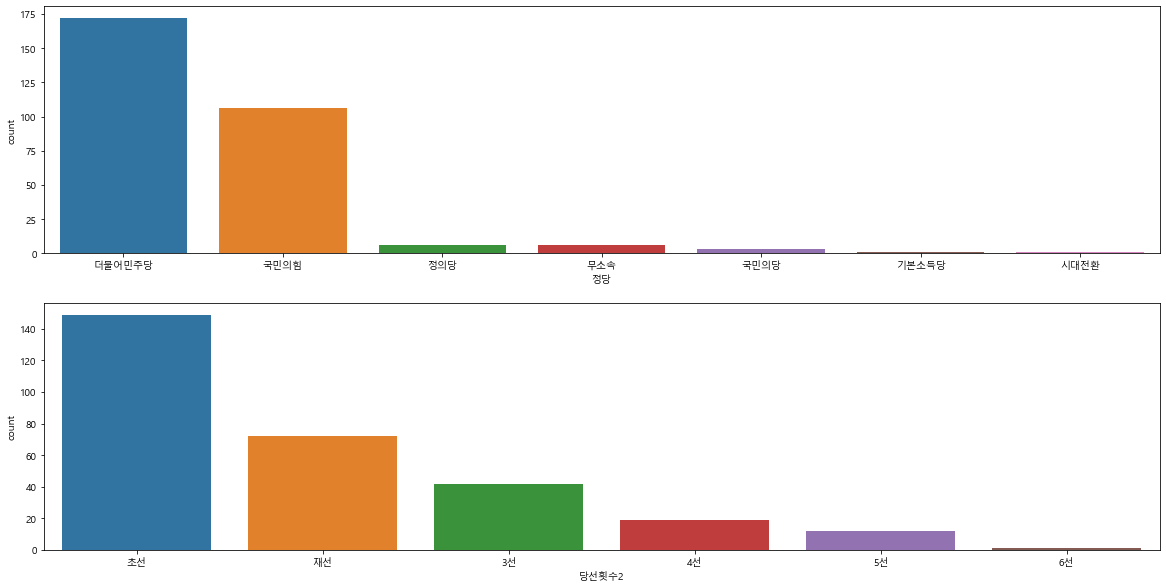

In [100]:
#x축 y축 2행 1열 
figure, (axes1,axes2) = plt.subplots(nrows=2, ncols=1)
#크기
figure.set_size_inches(20,10)

#x축
seaborn.countplot(data=member_df, x='정당', ax=axes1, order=member_df['정당'].value_counts().index)
seaborn.countplot(data=member_df, x='당선횟수2', ax=axes2, order=member_df['당선횟수2'].value_counts().index)